In [1]:
import rushd as rd
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap
import matplotlib

import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

In [2]:
experimentdir1 = rd.datadir/'flow'/'2024.07.22_CAG-mRu-RAS_BFP_4dpi_14dpi'
experimentdir2 = rd.datadir/'flow'/'2024.09.30_CAG-mRu-RAS_MOI'
experimentdir3 = rd.datadir/'flow'/'2024.11.04_CAG-mRu-RAS_MOI'

outputdir = rd.rootdir/'figures'/'Lenti_MOI_titration'

In [3]:
#rd.plot.plot_well_metadata(experimentdir1/'metadata.yaml')
#rd.plot.plot_well_metadata(experimentdir2/'metadata.yaml')
#rd.plot.plot_well_metadata(experimentdir3/'metadata.yaml')

# Load Data

In [3]:
data_columns = ['mRuby2-A','GFP-A']

df1a = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_4dpi',yaml_path=experimentdir1/'metadata.yaml',columns=data_columns)
df1b = rd.flow.load_csv_with_metadata(data_path=experimentdir1/'csv_14dpi',yaml_path=experimentdir1/'metadata.yaml',columns=data_columns)

df1a['dpi'] = '4dpi'
df1b['dpi'] = '14dpi'

df2a = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv_4dpi',yaml_path=experimentdir2/'metadata.yaml',columns=data_columns)
df2b = rd.flow.load_csv_with_metadata(data_path=experimentdir2/'csv_14dpi',yaml_path=experimentdir2/'metadata.yaml',columns=data_columns)

df2a['dpi'] = '4dpi'
df2b['dpi'] = '14dpi'

df3a = rd.flow.load_csv_with_metadata(data_path=experimentdir3/'csv_4dpi',yaml_path=experimentdir3/'metadata.yaml',columns=data_columns)
df3b = rd.flow.load_csv_with_metadata(data_path=experimentdir3/'csv_14dpi',yaml_path=experimentdir3/'metadata.yaml',columns=data_columns)

df3a['dpi'] = '4dpi'
df3b['dpi'] = '14dpi'

df = pd.concat([df1a,df1b,df2a,df2b,df3a,df3b])

df['condition'] = df['retro'] + ', MOI ' + df['MOI'].astype(str)
df['MOI'] = df['MOI'].astype(str)

Get rid of negative values

In [7]:
for i in np.arange(0,np.size(data_columns)):
    df = df.loc[df[data_columns[i]]>0]

# mRuby2 Gate

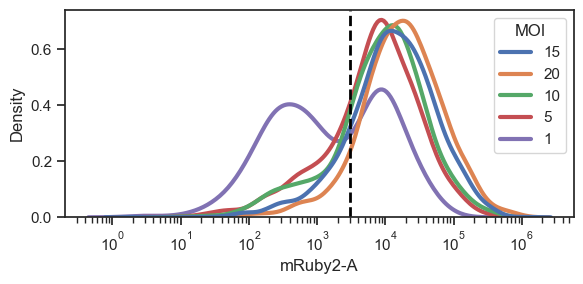

In [9]:
mRuby2_gate = 3000 # Set gate

sns.set_theme(style="ticks",font_scale=1)

data = df[(df['dpi'] == '4dpi') & (df['retro'].isin(['NIL DD','NIL SNAP-DD'])) & (df['rep'] == 'D')]

# Plot gate
fig = plt.figure(figsize=(6,3))
g = sns.kdeplot(data=data.sample(10000),x='mRuby2-A',hue='MOI',log_scale=True,common_norm=False,linewidth=3)
plt.axvline(x=mRuby2_gate,linestyle='--',color='black',linewidth=2)
#sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
fig.tight_layout()
plt.show()

# iMN Gate

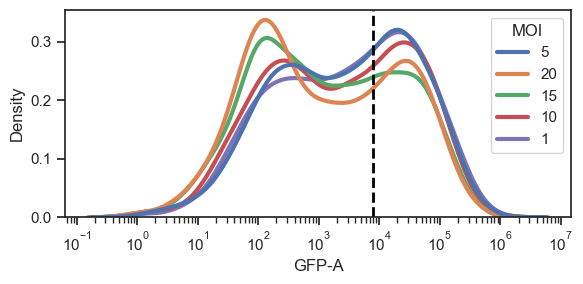

In [12]:
GFP_gate = 8 * 10**3 # Set gate at 8 * 10^3

data = df[(df['dpi'] == '14dpi') & (df['retro'].isin(['NIL DD','NIL SNAP-DD'])) & (df['rep'] == 'D')]

# Plot gate
fig=plt.figure(figsize=(6,3))
g = sns.kdeplot(data=data.sample(10000),x='GFP-A',hue='MOI',log_scale=True,common_norm=False,linewidth=3)
plt.axvline(x=GFP_gate,linestyle='--',color='black',linewidth=2)
#sns.move_legend(g, loc='upper left', bbox_to_anchor=(1,1), frameon=False)
fig.tight_layout()
plt.show()


# Make summary statistics dataframe

In [13]:
# Make a dataframe with summary statistics such as mean fluorescent intensity (MFI)
groups = ['retro','MOI','dpi','condition','well','rep']

summary_df = pd.concat([
    df.groupby(groups)['mRuby2-A'].apply(lambda x: np.mean(x > mRuby2_gate)*100).rename('(%) mRuby2+'),
    df.groupby(groups)['mRuby2-A'].apply(lambda x: np.sum(x > mRuby2_gate)).rename('# mRuby2+'),
    df.groupby(groups)['mRuby2-A'].apply(lambda x: np.size(x)).rename('Single Cells Count'),
    df.loc[df['mRuby2-A'] > mRuby2_gate].groupby(groups)['mRuby2-A'].apply(scipy.stats.gmean).rename('mRuby2+ MFI'),
    df.groupby(groups)['mRuby2-A'].apply(scipy.stats.gmean).rename('mRuby2 MFI'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.mean(x > GFP_gate)*100).rename('(%) iMN\nof all cells'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)).rename('iMN Yield'),
    df.groupby(groups)['GFP-A'].apply(lambda x: np.sum(x > GFP_gate)/10000 * 100).rename('(%) iMN yield\nper MEF plated')
    ], axis=1)
summary_df = summary_df.reset_index()

# Statistics you would like to plot later
cat2plot = ['mRuby2+ MFI']
bar2plot = ['(%) mRuby2+','# mRuby2+','Single Cells Count','(%) iMN\nof all cells','(%) iMN yield\nper MEF plated']
summary_df['MOI'] = summary_df['MOI'].astype(str)

# Plotting Functions

In [14]:
sns.set_theme(style="ticks",font_scale=1)

def custom_barplot(x,y,data,filename,height=3,width=6,hue=None,xlabel_rot=90,xlabel='',plottitle='',palette='viridis',order=None,hue_order=None,pairs=None,alpha=0.8,reps=None):
    aspect = width / height
    g = sns.catplot(x=x,y=y,data=data,height=height,aspect=aspect,palette=palette,kind='bar',hue=hue,order=order,hue_order=hue_order,alpha=alpha,errorbar='ci',legend=None)
    ax = plt.gca()
    
    if order != None:
        #labels = [ '\n'.join(wrap(l, 4)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    if hue == None:
        dodge = False
    elif hue != None:
        dodge = True

    if reps is None:
        g.map_dataframe(sns.stripplot, x=x,y=y, 
                    hue=hue, palette=["#404040"], 
                    alpha=0.8, dodge=dodge,order=order,hue_order=hue_order)
    
    marker_list = ['o', '^', 's', 'D', 'P', 'X']

    if reps is not None:
        for (j, rep) in enumerate(data[reps].unique()):
            sns.stripplot(
                ax=ax, data=data[data[reps] == rep],
                x=x, y=y,
                order=order,
                hue=hue,
                hue_order=hue_order,
                dodge=dodge, marker=marker_list[j],
                palette=['white'], size=5,
                edgecolor='black', linewidth=0.4,
                legend=None)

    if pairs != None:
        annotator = Annotator(ax,pairs,data=data,x=x,y=y,order=order)
        annotator.configure(test='t-test_ind',text_format='star',loc='inside', verbose=2)
        annotator.apply_and_annotate()
        #add_stat_annotation(ax, data=data, x=xcat, y=ycat, order=order,
        #            box_pairs=pairs,
        #            test='t-test_ind', text_format='star', verbose=2)

    ymin, ymax = ax.get_ylim()
    if ymax > 1000:
        k_formatter = matplotlib.ticker.FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
        ax.yaxis.set_major_formatter(k_formatter)

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False) # make plot bounded on all sides
    
    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')
    plt.xlabel(xlabel)
    plt.ylabel(y)
    plt.title(plottitle)

    if hue is not None:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0, frameon=False)  # Adjust bbox_to_anchor as needed

    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #g.tight_layout()
    g.savefig(outputdir/str(filename + '.svg'),dpi=300)



def custom_catplot(xcat,ycat,dataslice,savetitle,hue=None,hue_order=None,height=3,width=6,
                   xlabel_rot=0,xlabel='',plottitle='',order=None,palette=None,pairs=None,color=None,log=False,reps=None,errorbar=True):

    if hue == None:
        dodge = False
    elif hue != None:
        dodge = 0.4

    if errorbar == True:
        plt.figure(figsize=(width,height))
        g = sns.pointplot(x=xcat,y=ycat,data=dataslice,errorbar='se',join=False,capsize=0.22,
                        palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color,dodge=dodge)
        ax = plt.gca()

        marker_list = ['o', '^', 's', 'D', 'P', 'X']
        if reps is not None:
            for (j, rep) in enumerate(data[reps].unique()):
                sns.stripplot(
                    ax=ax, data=data[data[reps] == rep],
                    x=xcat, y=ycat,
                    order=order,
                    hue=hue,
                    hue_order=hue_order,
                    dodge=dodge, marker=marker_list[j],
                    #color='white',
                    palette=palette,
                    size=7,
                    edgecolor='white', linewidth=0.4,
                    legend=None)
                
        #g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')

    if errorbar == False:
        g = plt.figure(figsize=(width,height))
        ax = plt.gca()
        marker_list = ['o', '^', 's', 'D', 'P', 'X']
        if reps is not None:
            for (j, rep) in enumerate(data[reps].unique()):
                sns.stripplot(
                    #ax=ax,
                    data=data[data[reps] == rep],
                    x=xcat, y=ycat,
                    order=order,
                    hue=hue,
                    hue_order=hue_order,
                    dodge=dodge, marker=marker_list[j],
                    #color='white',
                    palette=palette,
                    size=7,
                    edgecolor='white', linewidth=0.4,
                    )
    

    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[0:len(hue_order)], labels[0:len(hue_order)], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)
    
    if order != None:
        #labels = [ '\n'.join(wrap(l, 16)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None
    
    ymin, ymax = ax.get_ylim()
    if log == True:
        ax.set_yscale('log')
    elif ymax > 1000:
        plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    
    if pairs != None:
        annotator = Annotator(ax,pairs,data=dataslice,x=xcat,y=ycat,order=order,hue=hue,hue_order=hue_order)
        annotator.configure(test='Kruskal',text_format='star',loc='inside')
        annotator.apply_and_annotate()

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
    
    if hue == None:
        plt.margins(x=0.3, y=0.3) # for some reason the plot is being weird and this makes it look better

    #plt.legend([],[], frameon=False)
    plt.xlabel(xlabel)
    plt.ylabel(ycat)
    plt.title(plottitle)
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #plt.tight_layout()
    plt.savefig(outputdir/str(savetitle + '.svg'),dpi=600)
    plt.show()


def scatter(xcat,ycat,data,order,hue,savetitle,figsize=(7,4),palette='muted',sci=None,log='none',xlim=None,ylim=None,title='', marker_col = None, marker_styles=None,line=False):
    xcatSEM = xcat + ' SEM'
    ycatSEM = ycat + ' SEM'

    # Make the figure
    fig, ax = plt.subplots(figsize=figsize)

    # plot errorbars
    plt.errorbar(x=xcat, y=ycat, xerr=xcatSEM, 
                yerr=ycatSEM,data=data, capsize=2, elinewidth=0.7,capthick=0.7,ls='none',color='grey')

    # Set markers if marker_col is provided
    if marker_col and marker_styles:
        markers = data[marker_col].map(marker_styles)
    else:
        markers = 'o'  # Default marker

    # plot connecting lines if desired
    if line == True:
        legend_exclude = -2# - len(order)
        for h in order:
            sns.lineplot(data=data[(data[hue] == h)],x=xcat, y=ycat, linestyle='-', markersize=8, label=h, color=palette[h],legend=False) 

    # Make the dots
    sns.scatterplot(data=data, x=xcat, y=ycat, hue=hue,hue_order=order,palette=palette,zorder=3,s=100, markers=marker_styles, style=marker_col)

    # Remove extra entries from the legend
    handles, labels = ax.get_legend_handles_labels()
    handles[-1] = []
    labels[-1]= []
    if line == True:
        handles[:len(order)] = []
        labels[:len(order)] = []
    ax.legend(handles=handles,labels=labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)

    # Figure title
    plt.title(title)

    # Change axis limit
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # Change x and y axes to log or scientific notation as desired
    if sci != None:
        plt.ticklabel_format(axis=sci,style='sci',scilimits=(0,0))
    if 'x' in log:
        ax.set_xscale('log')
    if 'y' in log:
        ax.set_yscale('log')
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #plt.tight_layout()    
    fig.savefig(outputdir/str(savetitle + '.svg'),dpi=300)



def jointplot(x,y,data,filename,height=3,hue=None,hue_order=None,
              plottitle='',palette='viridis',pairs=None,type='scatter',x_gate=None,y_gate=None,xlim=(1,5*10**7),ylim=(1,5*10**7)):

    g = sns.JointGrid(data=data, x=x, y=y, hue=hue,ratio=3, hue_order=hue_order,space=0,
                    xlim=xlim,ylim=ylim,height=height)
    
    # plot histograms in marginals
    g = g.plot_marginals(sns.kdeplot, fill=True, alpha=0.1, common_norm=False, log_scale=True, palette=palette)
    ax = g.ax_joint

    if 'scatter' in type:
        g.plot_joint(sns.scatterplot,s=3,hue_order=hue_order,palette=palette) #scatter plot in main graph
    if 'contour' in type:
        g = g.plot_joint(sns.kdeplot, alpha=0.8,palette=palette) #contour plot in main graph 
    if 'filled' in type:
        for cond in hue_order:
            g = g.plot_joint(sns.kdeplot, data=data[data[hue]==cond],alpha=0.5,fill=True,palette=palette) #filled contour plot in main graph 

    # Add in gates (optional)
    if x_gate:
        ax.axvline(x_gate, 0, 1, color='black')
    if y_gate:
        ax.axhline(y_gate, 0, 1, color='black')

    plt.title(plottitle)
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    sns.move_legend(g.ax_joint, loc='upper left', bbox_to_anchor=(1.35,1), frameon=False)
    g.savefig(outputdir/str(filename + '.svg'),dpi=300)


# Plot Results

Formatting

In [15]:
cat2plot = ['mRuby2+ MFI']
bar2plot = ['(%) mRuby2+','# mRuby2+','Single Cells Count','(%) iMN\nof all cells','(%) iMN yield\nper MEF plated','mRuby2+ MFI']

savedict = {'(%) mRuby2+':'(%) mRuby2+',
            '# mRuby2+':'# mRuby2+',
            'Single Cells Count':'cell-count',
            '(%) iMN\nof all cells':'purity',
            '(%) iMN yield\nper MEF plated':'yield',
            'mRuby2+ MFI':'mRuby2+ MFI',
            'mRuby2 MFI':'Total mRuby2 MFI',
            'Normalized (%) iMN yield\nper MEF plated':'norm_yield',
            'Normalized (%) iMN\nof all cells':'norm_purity',
            'Normalized mRuby2+ MFI (yield)':'norm-mRuby-yield',
            'Normalized mRuby2+ MFI (purity)':'norm-mRuby-purity'}

MOI_order= ['1','5','10','15','20']

## Bar Plots

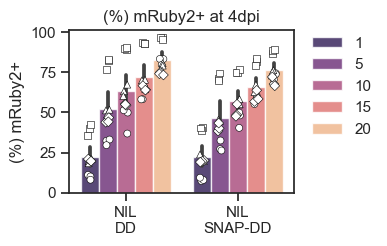

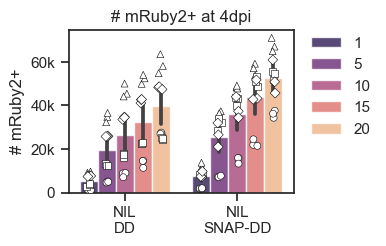

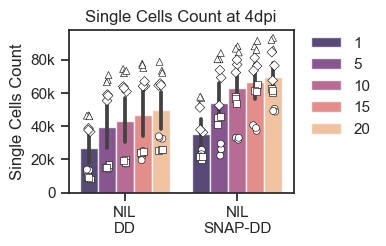

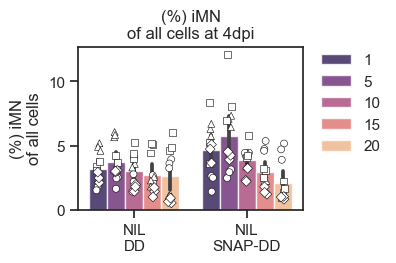

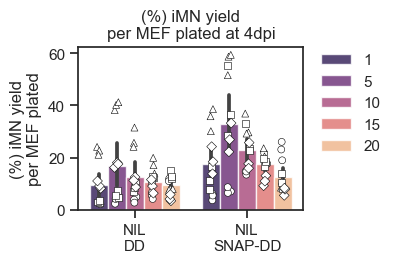

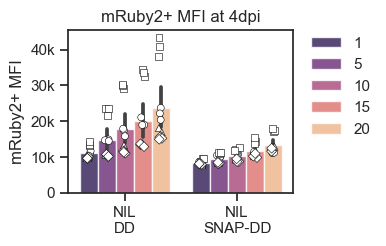

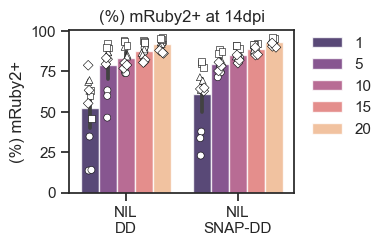

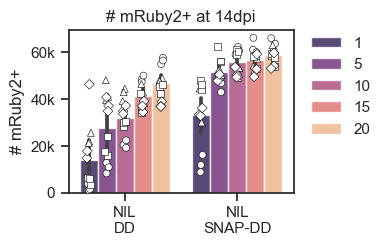

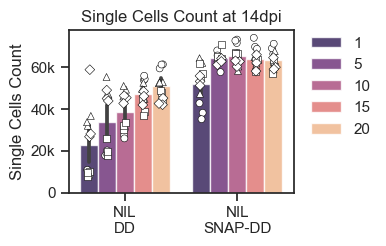

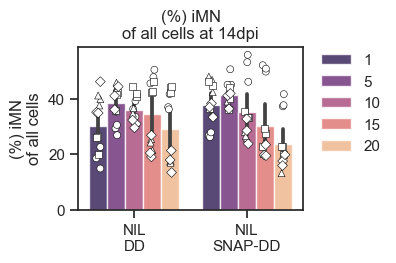

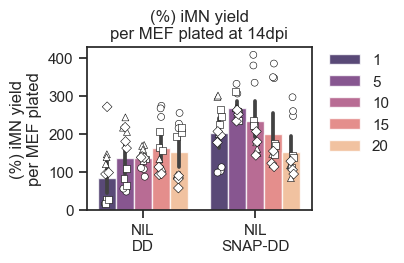

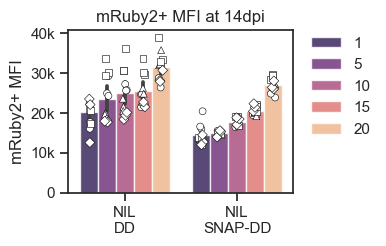

In [16]:
data = summary_df[(summary_df['dpi'] == '4dpi')]

for i in bar2plot:
    savetitle = savedict[i] + '_4dpi'
    custom_barplot('retro',i,data,savetitle,
                    order=['NIL DD','NIL SNAP-DD'],
                    hue='MOI',
                    hue_order=MOI_order,
                    palette='magma',
                    height=2.5,
                    width=3,
                    xlabel_rot=0,
                    alpha=0.8,
                    plottitle= i + ' at 4dpi',
                    reps='rep')

data = summary_df[(summary_df['dpi'] == '14dpi')]

for i in bar2plot:
    savetitle = savedict[i] + '_14dpi'
    custom_barplot('retro',i,data,savetitle,
                    order=['NIL DD','NIL SNAP-DD'],
                    hue='MOI',
                    hue_order=MOI_order,
                    palette='magma',
                    height=2.5,
                    width=3,
                    xlabel_rot=0,
                    alpha=0.8,
                    plottitle= i + ' at 14dpi',
                    reps='rep')

## Dot Plots

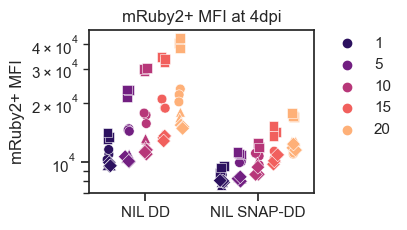

In [17]:
for i in cat2plot:

    data = summary_df[(summary_df['dpi'] == '4dpi') & (summary_df['MOI'].isin(MOI_order))]
    savetitle = 'catplot_4dpi_' + i
    custom_catplot('retro',i,data,savetitle,
                    height=2.5,
                    width=3,
                    order=['NIL DD','NIL SNAP-DD'],
                    hue = 'MOI',
                    hue_order=MOI_order,
                    log = True,
                    palette='magma',
                    plottitle= i + ' at 4dpi',
                    reps='rep',
                    errorbar=False)

# Normalizing mRuby2+ MFI

In [18]:
summary_df = summary_df[summary_df['retro'] != 'None']

In [19]:
for retro_value in summary_df['retro'].unique():
    for rep_value in summary_df['rep'].unique():
        # Find the MOI that corresponds to the maximum mean '(%) iMN yield\nper MEF plated' at 14dpi for a given condition
        slice = summary_df.drop(columns=['well'])
        means = slice.groupby(['MOI','retro','condition','dpi','rep']).mean().reset_index()

        # Normalize by the peak yield -----------------------------------------------------------

        max_yield_row = means.loc[
            (means['retro'] == retro_value) &
            (means['rep'] == rep_value) &
            (means['dpi'] == '14dpi')
        ].nlargest(1, '(%) iMN yield\nper MEF plated')

        if not max_yield_row.empty:
            # Get the MOI value associated with the maximum yield at 14dpi
            max_moi = max_yield_row['MOI'].values[0]


            # Find the 'mRuby2+ MFI' at 4dpi for this specific MOI, retro, and rep
            mRuby2_mfi_4dpi = summary_df.loc[
                (summary_df['retro'] == retro_value) &
                (summary_df['rep'] == rep_value) &
                (summary_df['dpi'] == '4dpi') &
                (summary_df['MOI'] == max_moi),
                'mRuby2+ MFI'
            ].values

            # Check if we found a matching 'mRuby2+ MFI' value
            if mRuby2_mfi_4dpi.size > 0:
                normalization_value = mRuby2_mfi_4dpi[0]

                # Normalize 'mRuby2+ MFI' for all rows with the same retro and rep
                summary_df.loc[
                    (summary_df['retro'] == retro_value) & 
                    (summary_df['rep'] == rep_value), 
                    'Normalized mRuby2+ MFI (yield)'
                ] = summary_df.loc[
                    (summary_df['retro'] == retro_value) & 
                    (summary_df['rep'] == rep_value), 
                    'mRuby2+ MFI'
                ] / normalization_value
            
            

            # Calculate the mean yield for this MOI within the same retro and rep group
            mean_yield_for_max_moi = summary_df.loc[
                (summary_df['retro'] == retro_value) &
                (summary_df['rep'] == rep_value) &
                (summary_df['dpi'] == '14dpi') &
                (summary_df['MOI'] == max_moi),
                '(%) iMN yield\nper MEF plated'
            ].mean()

            # Normalize '(%) iMN yield\nper MEF plated' by this mean value for all rows in the group
            summary_df.loc[
                (summary_df['retro'] == retro_value) &
                (summary_df['rep'] == rep_value),
                'Normalized (%) iMN yield\nper MEF plated'
            ] = summary_df.loc[
                (summary_df['retro'] == retro_value) &
                (summary_df['rep'] == rep_value),
                '(%) iMN yield\nper MEF plated'
            ] / mean_yield_for_max_moi


        # Normalize by the peak purity -----------------------------------------------------------

        max_purity_row = means.loc[
                    (means['retro'] == retro_value) &
                    (means['rep'] == rep_value) &
                    (means['dpi'] == '14dpi')
                ].nlargest(1, '(%) iMN\nof all cells')

        if not max_purity_row.empty:
            # Get the MOI value associated with the maximum yield at 14dpi
            max_moi = max_purity_row['MOI'].values[0]

            # Find the 'mRuby2+ MFI' at 4dpi for this specific MOI, retro, and rep
            mRuby2_mfi_4dpi = summary_df.loc[
                (summary_df['retro'] == retro_value) &
                (summary_df['rep'] == rep_value) &
                (summary_df['dpi'] == '4dpi') &
                (summary_df['MOI'] == max_moi),
                'mRuby2+ MFI'
            ].values

            # Check if we found a matching 'mRuby2+ MFI' value
            if mRuby2_mfi_4dpi.size > 0:
                normalization_value = mRuby2_mfi_4dpi[0]

                # Normalize 'mRuby2+ MFI' for all rows with the same retro and rep
                summary_df.loc[
                    (summary_df['retro'] == retro_value) & 
                    (summary_df['rep'] == rep_value), 
                    'Normalized mRuby2+ MFI (purity)'
                ] = summary_df.loc[
                    (summary_df['retro'] == retro_value) & 
                    (summary_df['rep'] == rep_value), 
                    'mRuby2+ MFI'
                ] / normalization_value

            # Calculate the mean yield for this MOI within the same retro and rep group
            mean_purity_for_max_moi = summary_df.loc[
                (summary_df['retro'] == retro_value) &
                (summary_df['rep'] == rep_value) &
                (summary_df['dpi'] == '14dpi') &
                (summary_df['MOI'] == max_moi),
                '(%) iMN\nof all cells'
            ].mean()

            # Normalize '(%) iMN yield\nper MEF plated' by this mean value for all rows in the group
            summary_df.loc[
                (summary_df['retro'] == retro_value) &
                (summary_df['rep'] == rep_value),
                'Normalized (%) iMN\nof all cells'
            ] = summary_df.loc[
                (summary_df['retro'] == retro_value) &
                (summary_df['rep'] == rep_value),
                '(%) iMN\nof all cells'
            ] / mean_purity_for_max_moi


In [20]:
slice = summary_df.drop(columns=['well'])

# Find the mean and standard error of the mean (SEM) for all technical and biological replicates in a given condition:
means = slice.groupby(['MOI','retro','condition','dpi','rep']).mean()
se = slice.groupby(['MOI','retro','condition','dpi','rep']).sem()
se.columns = [col + ' SEM' for col in se.columns] # Rename the columns to include standard error of the mean
stats = means.join(se) # Combine means and standard errors into a single dataframe
stats.reset_index(drop=False,inplace=True) # Remove index

# Show normalization process

In [21]:
stats['condition_2'] = stats['retro'] + ', rep ' + stats['rep']

stats.condition_2.unique()

condition_palette = {'NIL DD, rep A':'#50a37f','NIL SNAP-DD, rep A':'#74c7c4',
                     'NIL DD, rep B':'#4674b9','NIL SNAP-DD, rep B':'#cc75ad',
                     'NIL DD, rep C':'#ee7776','NIL SNAP-DD, rep C':'#e4bd67',
                     'NIL DD, rep D':'#987cb1','NIL SNAP-DD, rep D':'#707070'}

marker_styles = {1:'^', 5:'X', 10:'d',15:'o',20:'v'}


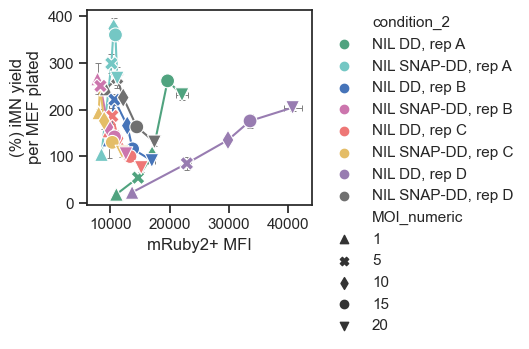

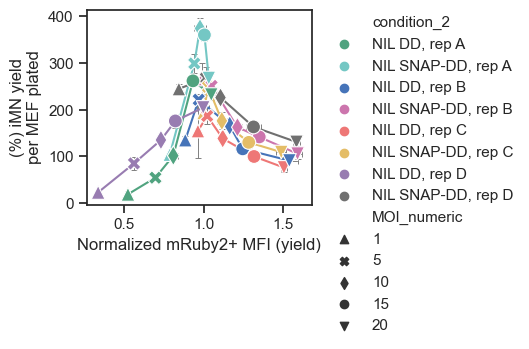

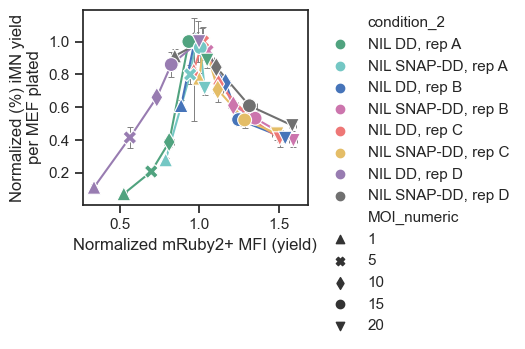

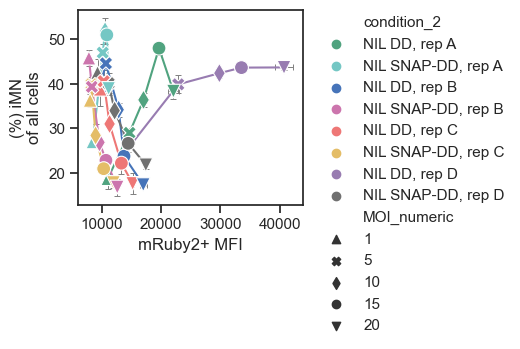

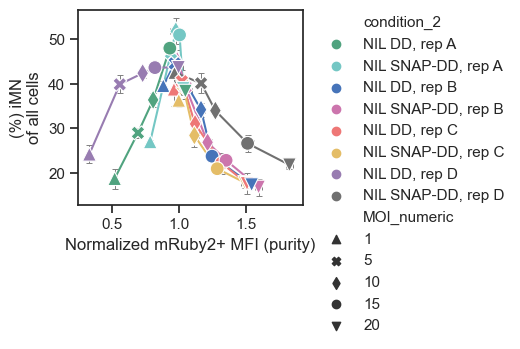

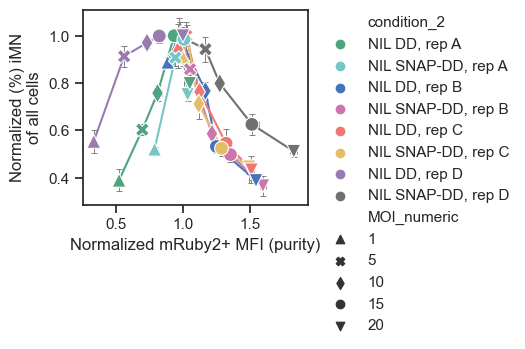

In [22]:
# plot steps of data normalization for iMN yield

xlist = ['mRuby2+ MFI','Normalized mRuby2+ MFI (yield)','Normalized mRuby2+ MFI (yield)',
         'mRuby2+ MFI','Normalized mRuby2+ MFI (purity)','Normalized mRuby2+ MFI (purity)']
ylist = ['(%) iMN yield\nper MEF plated','(%) iMN yield\nper MEF plated','Normalized (%) iMN yield\nper MEF plated',
         '(%) iMN\nof all cells','(%) iMN\nof all cells','Normalized (%) iMN\nof all cells']
condition_2_order = ['NIL DD, rep A','NIL SNAP-DD, rep A',
                     'NIL DD, rep B','NIL SNAP-DD, rep B',
                     'NIL DD, rep C','NIL SNAP-DD, rep C',
                     'NIL DD, rep D','NIL SNAP-DD, rep D']

for x,y in zip(xlist,ylist):
    slice_4dpi = stats[(stats.dpi == '4dpi')][['rep','MOI','retro','condition_2',x,x + ' SEM']] # mRuby2 data at 4 dpi
    slice_14dpi = stats[(stats.dpi == '14dpi')][['rep','MOI','retro','condition_2',y,y + ' SEM']] # iMN data at 14dpi
    slice = pd.merge(slice_4dpi, slice_14dpi, on=['rep','MOI','retro','condition_2']) # merge 4 dpi and 14 dpi data

    savetitle = 'rainbow-line_' + savedict[y] + '_14dpi_vs_'+ savedict[x]

    # Make sure marker legend is in correct order
    slice = slice[(slice['MOI'].isin(MOI_order))]
    slice['MOI_numeric'] = pd.to_numeric(slice['MOI'])
    slice= slice.sort_values(by=['MOI_numeric'])
    
    scatter(x,y,slice,
            order = condition_2_order,
            hue='condition_2',
            savetitle=savetitle,
            palette=condition_palette,
            figsize=(3,3),
            marker_col='MOI_numeric',
            marker_styles=marker_styles,
            line=True)


# Single color plots

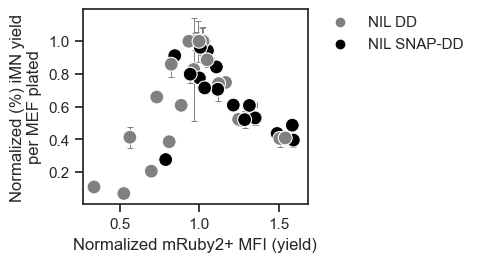

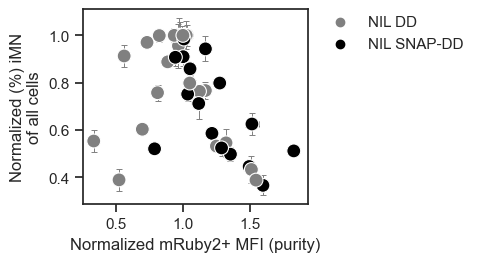

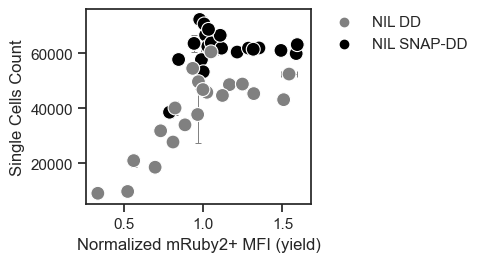

In [23]:
marker_styles = {'1':'o', '5':'^', '10':'d','15':'X','20':'v'}
marker_styles = {1:'^', 5:'X', 10:'d',15:'o',20:'v'}

# plot yield and cell count

columns = ['rep','MOI','retro','Normalized mRuby2+ MFI (yield)','Normalized mRuby2+ MFI (yield) SEM']
y2plot = ['(%) iMN yield\nper MEF plated','Single Cells Count',
          'Normalized (%) iMN yield\nper MEF plated']

xlist = ['Normalized mRuby2+ MFI (yield)',          'Normalized mRuby2+ MFI (purity)', 'Normalized mRuby2+ MFI (yield)']
ylist = ['Normalized (%) iMN yield\nper MEF plated','Normalized (%) iMN\nof all cells','Single Cells Count']

for x,y in zip(xlist,ylist):
    slice_4dpi = stats[(stats.dpi == '4dpi')][['rep','MOI','retro',x,x+' SEM']]
    slice_14dpi = stats[(stats.dpi == '14dpi')][['rep','MOI','retro',y,y + ' SEM']]
    slice = pd.merge(slice_4dpi, slice_14dpi, on=['rep','MOI','retro'])
    savetitle = 'black_' + savedict[y] + '_14dpi_vs_'+ savedict[x]

    slice = slice[(slice['MOI'].isin(MOI_order))]
    slice['MOI_numeric'] = pd.to_numeric(slice['MOI'])
    slice= slice.sort_values(by=['MOI_numeric'])
    
    scatter(x,y,slice,
            order = ['NIL DD','NIL SNAP-DD'],
            hue='retro',
            savetitle=savetitle,
            palette={'NIL DD':'grey','NIL SNAP-DD':'black'},
            figsize=(3,3),
            #marker_col='MOI_numeric',
            #marker_styles=marker_styles
            )


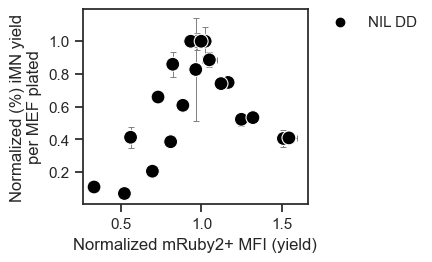

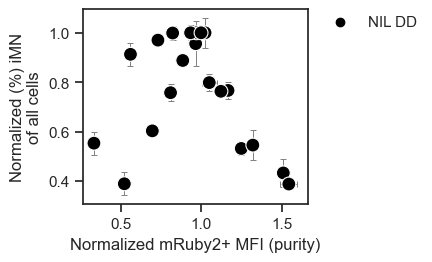

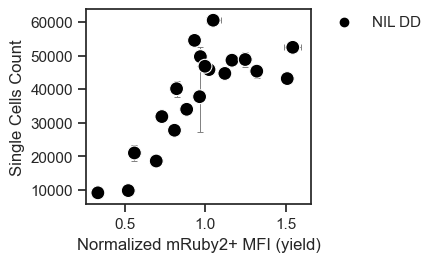

In [24]:
marker_styles = {'1':'o', '5':'^', '10':'d','15':'X','20':'v'}
marker_styles = {1:'^', 5:'X', 10:'d',15:'o',20:'v'}

# plot yield and cell count

columns = ['rep','MOI','retro','Normalized mRuby2+ MFI (yield)','Normalized mRuby2+ MFI (yield) SEM']
y2plot = ['(%) iMN yield\nper MEF plated','Single Cells Count',
          'Normalized (%) iMN yield\nper MEF plated']

xlist = ['Normalized mRuby2+ MFI (yield)',          'Normalized mRuby2+ MFI (purity)', 'Normalized mRuby2+ MFI (yield)']
ylist = ['Normalized (%) iMN yield\nper MEF plated','Normalized (%) iMN\nof all cells','Single Cells Count']

for x,y in zip(xlist,ylist):
    slice_4dpi = stats[(stats.dpi == '4dpi')][['rep','MOI','retro',x,x+' SEM']]
    slice_14dpi = stats[(stats.dpi == '14dpi')][['rep','MOI','retro',y,y + ' SEM']]
    slice = pd.merge(slice_4dpi, slice_14dpi, on=['rep','MOI','retro'])
    savetitle = 'black_noSDD_' + savedict[y] + '_14dpi_vs_'+ savedict[x]

    slice = slice[(slice['MOI'].isin(MOI_order))]
    slice['MOI_numeric'] = pd.to_numeric(slice['MOI'])
    slice= slice.sort_values(by=['MOI_numeric'])
    
    scatter(x,y,slice[slice.retro == 'NIL DD'],
            order = ['NIL DD'],
            hue='retro',
            savetitle=savetitle,
            palette={'NIL DD':'black','NIL SNAP-DD':'grey'},
            figsize=(3,3),
            #marker_col='MOI_numeric',
            #marker_styles=marker_styles
            )
